Train Accuracy: 51.43%
Test Accuracy: 46.67%


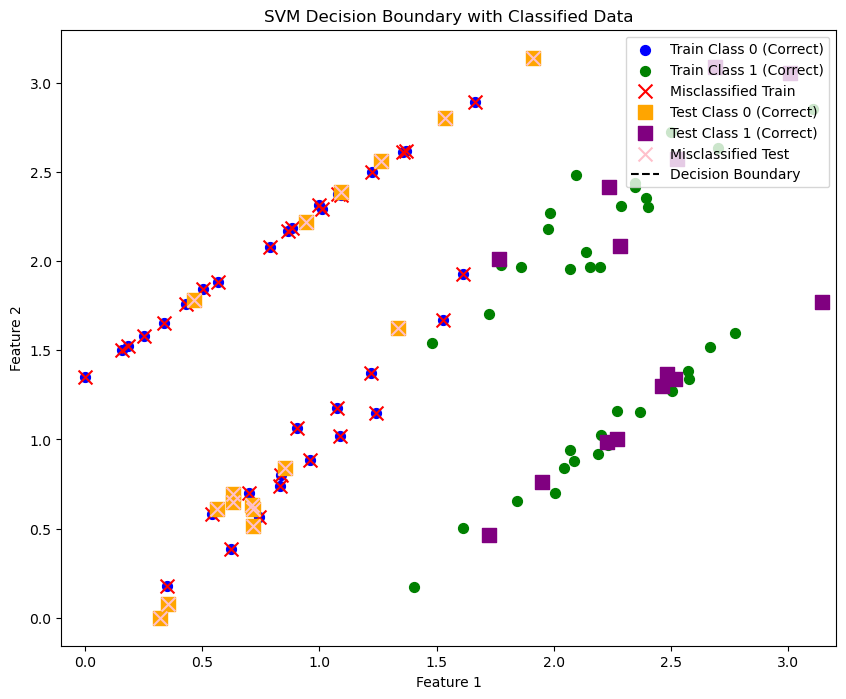

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

# Step 1: Generate a toy dataset
X, y = make_classification(n_samples=100, n_features=2, n_informative=2,
                           n_redundant=0, random_state=42)

# Normalize the data to the range [0, π] for quantum circuit parameters using min-max normalization
X = np.pi * (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Define the custom quantum feature map
def construct_circuit(x):
    qc = QuantumCircuit(len(x))
    # Apply Hadamard gates to all qubits
    qc.h(range(len(x)))
    for i, xi in enumerate(x):  # Apply parameterized rotations using rx gates with xi as theta on qubit i
        qc.rx(xi, i)
    return qc

# Step 4: Initialize the quantum simulator backend
backend = AerSimulator()

# Helper function to compute statevectors
def compute_statevectors(X):
    statevectors = []
    for x in X:
        qc = construct_circuit(x)
        qc.save_statevector()
        job = transpile(qc, backend)
        result = backend.run(job).result()
        statevectors.append(result.get_statevector())
    return np.array(statevectors)

# Step 5: Precompute statevectors
statevectors_train = compute_statevectors(X_train)
statevectors_test = compute_statevectors(X_test)

# Step 6: Compute the kernel matrix
def compute_kernel_matrix(statevectors1, statevectors2):
    return np.abs(np.dot(statevectors1, statevectors2.conj().T)) ** 2

# Compute kernel matrices
kernel_train = compute_kernel_matrix(statevectors_train, statevectors_train)
kernel_test = compute_kernel_matrix(statevectors_test, statevectors_train)

# Step 7: Train the SVM with the precomputed kernel
svm = SVC(kernel='precomputed')
svm.fit(kernel_train, y_train)

# Step 8: Make predictions on the test set and train set using kernel_train and kernel_test
y_pred_test = svm.predict(kernel_test)
y_pred_train = svm.predict(kernel_train)

# Step 9: Evaluate the accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Step 10: Visualize decision boundary with classified data
def plot_points_and_boundary(X_train, y_train, y_pred_train,
                              X_test, y_test, y_pred_test,
                              model, statevectors_train):
    plt.figure(figsize=(10, 8))

    # Plot training data points
    plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
                color='blue', s=50, label='Train Class 0 (Correct)')
    plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
                color='green', s=50, label='Train Class 1 (Correct)')

    # Plot misclassified training points
    incorrect_train = y_train != y_pred_train
    plt.scatter(X_train[incorrect_train, 0], X_train[incorrect_train, 1],
                color='red', marker='x', s=100, label='Misclassified Train')

    # Plot testing data points
    plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1],
                color='orange', s=100, marker='s', label='Test Class 0 (Correct)')
    plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1],
                color='purple', s=100, marker='s', label='Test Class 1 (Correct)')

    # Plot misclassified testing points
    incorrect_test = y_test != y_pred_test
    plt.scatter(X_test[incorrect_test, 0], X_test[incorrect_test, 1],
                color='pink', marker='x', s=100, label='Misclassified Test')

    # Create a grid for plotting the decision boundary
    x_min, x_max = X_train[:, 0].min() - 0.1, X_train[:, 0].max() + 0.1
    y_min, y_max = X_train[:, 1].min() - 0.1, X_train[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points = (grid_points - X_train.min(axis=0)) / (X_train.max(axis=0) - X_train.min(axis=0)) * np.pi

    # Precompute statevectors for grid points
    statevectors_grid = compute_statevectors(grid_points)
    kernel_grid = compute_kernel_matrix(statevectors_grid, statevectors_train)

    # Predict decision boundary
    zz = model.decision_function(kernel_grid).reshape(xx.shape)
    plt.contour(xx, yy, zz, levels=[0], colors='black', linewidths=2, linestyles='--')
    plt.plot([], [], 'k--', label='Decision Boundary')  # Add proxy for legend

    plt.title("SVM Decision Boundary with Classified Data")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(loc='upper right')
    plt.show()

# Plot points and final decision boundary
plot_points_and_boundary(X_train, y_train, y_pred_train, X_test, y_test, y_pred_test, svm, statevectors_train)
